In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import json
from eval_model_cached import predict_from_model

Using TensorFlow backend.


In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
def indexes(array, small=-float('inf'), big=float('inf')):
    '''returns positions (rows) in 'array' where array is between 'right' and 'left' '''
    l=[]
    for i in range(0, len(array)):
        if small <= array[i] <= big:
            l.append(i)
    return l

# Load data and scores

In [5]:
#Wanna save the plots?
save=False

In [6]:
Versuch=4
Versuch="Versuch"+str(Versuch)
#df_log = pd.read_csv("training.log")
df_log = pd.read_csv("/srv/data/mfichtner/ParticleListTraining/"+Versuch+"/training.log")

with open("/srv/data/mfichtner/ParticleListTraining/input_config2/weight_params.json") as f:
    weight_params = json.load(f)
    class_weights = np.array(weight_params["class_weights"])
    mean_weight = float(weight_params["mean_weight"])

# Convergence curve

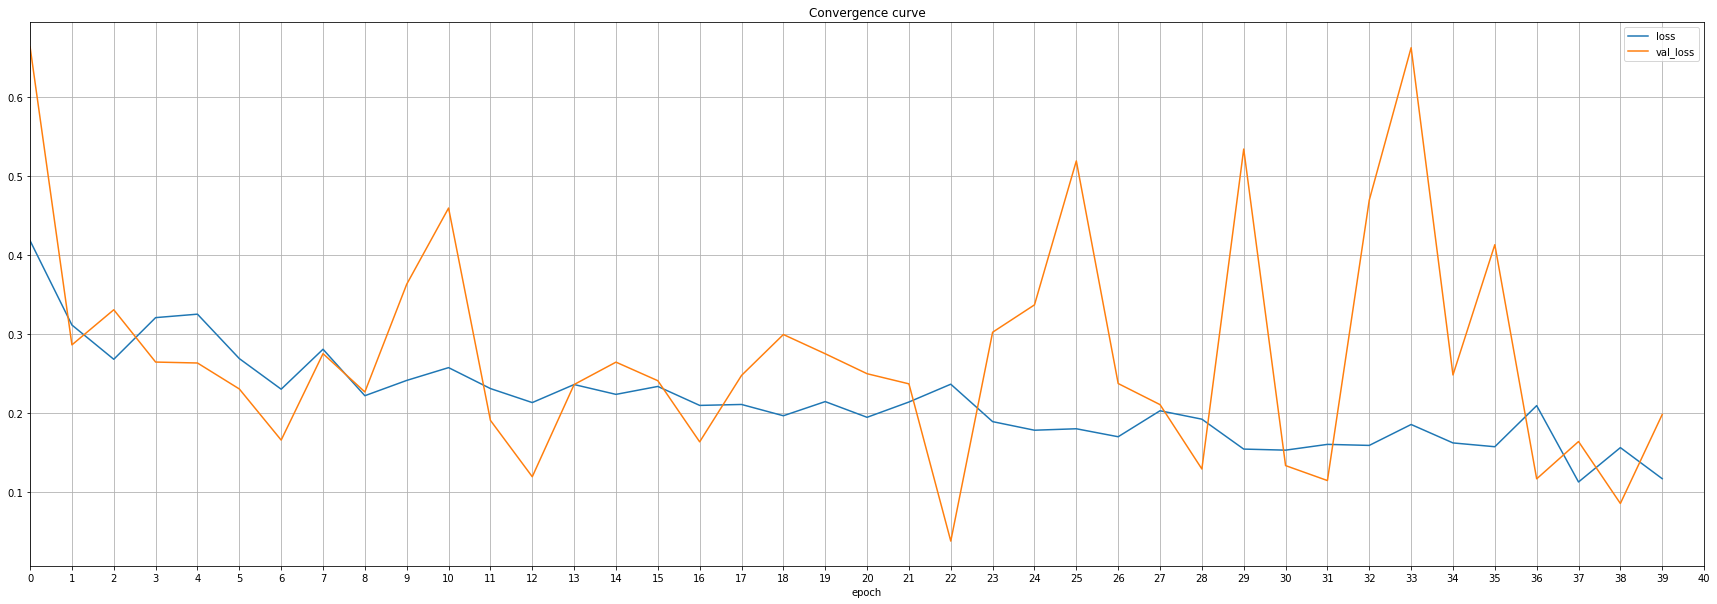

In [7]:
fig, ax = plt.subplots(figsize=(30,10))
df_log.plot("epoch", "loss", ax=ax)
df_log.plot("epoch", "val_loss", ax=ax, title='Convergence curve')
plt.xticks(np.arange(0, len(df_log)+1, 1))
#ylim=(0,0.6)
#plt.ylim(ylim)
#plt.yticks(np.arange(list(ylim)[0], list(ylim)[1]+0.01, 0.02))
plt.grid()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Convergence_curve.png')
plt.show()

# Calculate NN output

In [ ]:
a= #interrupt

In [8]:
weightepoch=str("weights40.28-0.2111")+".h5"
scores_train=np.load("scores_train_"+weightepoch+".npy")
scores_test=np.load("scores_test_"+weightepoch+".npy")

labels_train=np.load("labels_train_"+weightepoch+".npy")
labels_test=np.load("labels_test_"+weightepoch+".npy")

w_train=np.load("w_train_"+weightepoch+".npy")
w_test=np.load("w_test_"+weightepoch+".npy")

# ROC curve

In [89]:
fpr_train, tpr_train, thr_train = roc_curve(labels_train, scores_train, sample_weight=w_train)

In [90]:
fpr_test, tpr_test, thr_test = roc_curve(labels_test, scores_test, sample_weight=w_test)

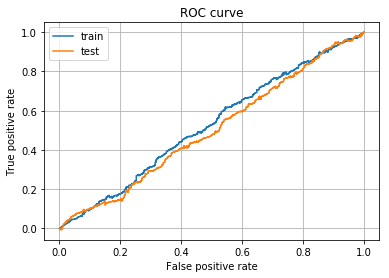

In [91]:
plt.plot(fpr_train, tpr_train, label="train")
plt.plot(fpr_test, tpr_test, label="test")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.grid()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/ROC_curve_'+weightepoch+'.png')
plt.show()

### Verify cross-entropy

In [82]:
y_pred_train = np.array([(scores_train[i]-0.0000001) if scores_train[i]==1 else scores_train[i] for i in range(len(scores_train))]).reshape(-1)
y_pred_test  = np.array([(scores_test[i]-0.0000001) if scores_test[i]==1 else scores_test[i] for i in range(len(scores_test))]).reshape(-1)
#-0.0...1 to avoid ln(0) if scores==1

y_true_train = labels_train.astype(int)
y_true_test  = labels_test.astype(int)

In [92]:
L_train = -(w_train*(y_true_train * np.log(y_pred_train) + (1.-y_true_train)*np.log(1.-y_pred_train))).sum() / len(y_true_train)
L_train

1.3870325505622498

In [93]:
L_test = -(w_test*(y_true_test * np.log(y_pred_test) + (1.-y_true_test)*np.log(1.-y_pred_test))).sum() / len(y_true_test)
L_test

2.9409883841079902

## NN Output distribution

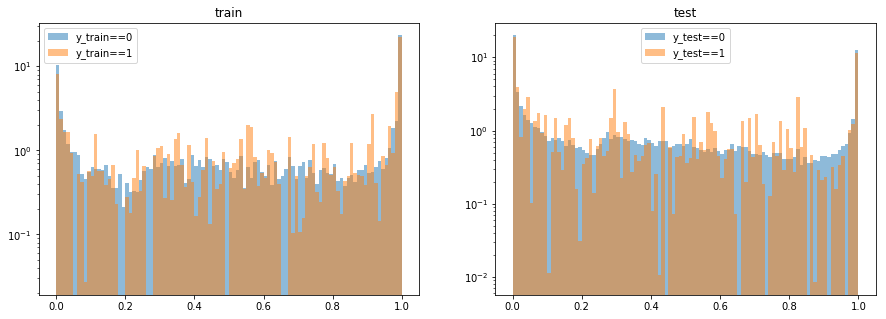

In [95]:
opts = dict(bins=100, range=(0, 1.), alpha=0.5, density=True)
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("train")
plt.hist(scores_train[y_true_train==0], weights=w_train[y_true_train==0], **opts, label='y_train==0')
plt.hist(scores_train[y_true_train==1], weights=w_train[y_true_train==1], **opts, label='y_train==1')
#plt.stem([THR_cut_train], [1e3], linefmt='r', markerfmt='C3o', label="thr cut: " + str(THR_cut_train))
plt.yscale("log")
plt.legend()

plt.subplot(122)
plt.title("test")
plt.hist(scores_test[y_true_test==0], weights=w_test[y_true_test==0], **opts, label='y_test==0')
plt.hist(scores_test[y_true_test==1], weights=w_test[y_true_test==1], **opts, label='y_test==1')
#plt.stem([THR_cut_test], [1e3], linefmt='r', markerfmt='C3o', label="thr cut: " + str(THR_cut_test))
plt.yscale("log")
plt.legend()

if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/NN_Output_'+weightepoch+'.png')
plt.show()

In [ ]:
a= #interrupt

# Efficiency vs Purity

In [59]:
# class weights should give us the ratio between fail/pass base rates
r = class_weights[1] / class_weights[0]
Purity_train = tpr_train/(tpr_train + r*fpr_train)
Purity_test = tpr_test/(tpr_test + r*fpr_test)

/home/michi147/miniconda3/envs/ml-p3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/michi147/miniconda3/envs/ml-p3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/michi147/miniconda3/envs/ml-p3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/michi147/miniconda3/envs/ml-p3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


# Maximal Purity

## Purity vs. Efficiency

In [ ]:
# Efficiency vs. Purity
fig, ax1 = plt.subplots()

ax1.plot(tpr_train, Purity_train, 'b', label="train")
ax1.plot(tpr_test, Purity_test, 'orange', label="test")
ax1.plot(TPR2_withoutNN, Purity2_withoutNN,'m', label="1st study")
ax1.stem([TPR_cut_train], [5e-1], 'r', 'C3o', label="TPR cut (train)")
ax1.set_xlabel("True positive rate")
ax1.set_ylabel("True positive purity")
ax1.set_yscale('log')
ax1.set_ylim(3e-6, 1)
#ax1.set_ylim(-0.05,0.3)
#ax1.legend()

ax2=ax1.twinx()
ax2.plot(tpr_train, thr_train,'g', label="THR (train)")
#ax2.plot(tpr_test, thr_test, 'y', label="THR (test)")
ax2.set_ylabel("Threshold")
#ax2.set_yscale('log')
plt.title("Purity vs. Efficiency")
#ax2.legend(loc='best')
fig.legend(loc=(0.63,0.63))
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/PurityEfficiency_'+weightepoch+'.png')
plt.show()

## Purity vs. Threshold

In [ ]:
plt.plot(thr_train, Purity_train, label="train")
plt.plot(thr_test, Purity_test, label="test")
plt.yscale('log')
#plt.ylim(0.,0.3)
#plt.xlim(0.98,1.001)
plt.xlabel("Threshold")
plt.ylabel("Purity")
plt.legend()
plt.title("Purity vs. Threshold")
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/PurityThreshold_'+weightepoch+'.png')
plt.show()

In [ ]:
Purity_test=pd.DataFrame(Purity_test)
tpr_test=pd.DataFrame(tpr_test)
Purity_train=pd.DataFrame(Purity_train)
tpr_train=pd.DataFrame(tpr_train)

#maximal Purity

#train
Pmax_train=float(Purity_train.dropna().max())
print("maximale Purity, train:", Pmax_train)

#test
Pmax_test=float(Purity_test.dropna().max())
print("maximale Purity, test:", Pmax_test)

Purity_test=np.array(Purity_test)
tpr_test=np.array(tpr_test)
Purity_train=np.array(Purity_train)
tpr_train=np.array(tpr_train)

#TPR of maximal Purity
l_Purity_max = indexes(Purity_train, Pmax_train, Pmax_train)
print("TPR of maximal purity, train:", tpr_train[l_Purity_max[0]])
print("Sim time red at max. purity: see below")

# TPR Cut

In [ ]:
#Purity before NN: from class_weights (saved in preprocess.py)
#see own calculation
P_before=class_weights[0]/(class_weights[0]+class_weights[1])
P_before

In [ ]:
#TPR cut

#test
l_test_cut = indexes(tpr_test, 0.6, 0.601)

TPR_cut_test = tpr_test[l_test_cut[0]]
P_cut_test = Purity_test[l_test_cut[0]]
THR_cut_test = thr_test[l_test_cut[0]]

#train
l_train_cut = indexes(tpr_train, 0.6, 0.601)

TPR_cut_train = tpr_train[l_train_cut[0]]
P_cut_train = Purity_train[l_train_cut[0]]
THR_cut_train = thr_train[l_train_cut[0]]

print("TPR cut, train:", TPR_cut_train)
print("Purity cut, train:", P_cut_train)
print("THR cut, train:", THR_cut_train)
print("Relative Abweichung zu Pmax, train:", (Pmax_train-P_cut_train)/Pmax_train)
print()
print("TPR cut, test:", TPR_cut_test)
print("Purity cut, test:", P_cut_test)
print("THR cut, test:", THR_cut_test)
print("Relative Abweichung zu Pmax, test:", (Pmax_test-P_cut_test)/Pmax_test)


# Simulation time

## t'/t = p/p'

In [ ]:
#Simulation time ratio = t'/t =:T
#t'/t = Purity/Purity'
#': with NN

#test
T_Pmax_test=(P_before/Pmax_test)
print("Simulation time ratio, max Purity, test:", T_Pmax_test)

T_cut_test=(P_before/P_cut_test)
print("Simulation time ratio, cut Purity, test:", T_cut_test)

#train
T_Pmax_train=(P_before/Pmax_train)
print("Simulation time ratio, max Purity, train:", T_Pmax_train)

T_cut_train=(P_before/P_cut_train)
print("Simulation time ratio, cut Purity, train:", T_cut_train)

## t'/t = fkt(p, p', f)

In [ ]:
#Check if there are 0's or NaN's:

#I=np.arange(0,len(Purity_train))

#mask=[np.array([(Purity_train[i]!=0) & (Purity_train[i]!=np.nan) &
#      (tpr_train[i]!=0) & (tpr_train[i]!=np.nan) &
#      (fpr_train[i]!=0) & (fpr_train[i]!=np.nan)
#      for i in I]).tolist()[i][0] for i in I]

#rechnet ewig

#mask

In [ ]:
f=np.array([0.5, 0.1, 0.05, 0.01, 0.005]) #ratio between generation and simulation/reconstruction time

#calculate t'/t:
STR_f_train = np.array([[float((1/(1+f[j]) * (P_before/Purity_train[i] + P_before*f[j]*(1/tpr_train[i]+(1/Purity_train[i] -1)/fpr_train[i]))))
               for i in range(1,len(Purity_train))] for j in range(0,len(f))])
#STR_f_train

In [ ]:
#Sim time reduction 1-t'/t for different f at cut for choise of TPR (train)
Time_red_cut_train=[1-STR_f_train[i][l_train_cut[0]] for i in range(len(f))]

for j in range(len(f)):
    print("f =", f[j])
    print(" sim tim red at TPR cut, train:", Time_red_cut_train[j])

In [ ]:
#Same calculation for test:
STR_f_test = np.array([[float((1/(1+f[j]) * (P_before/Purity_test[i] + P_before*f[j]*(1/tpr_test[i]+(1/Purity_test[i] -1)/fpr_test[i]))))
               for i in range(1,len(Purity_test))] for j in range(0,len(f))])
#STR_f_test

In [ ]:
#Sim time reduction for different f at cut for choise of TPR (test)
Time_red_cut_test=[1-STR_f_test[i][l_test_cut[0]] for i in range(len(f))]

for j in range(len(f)):
    print("f =", f[j])
    print(" sim tim red at TPR cut, test:", Time_red_cut_test[j])

## Sim time reduction at max. Purity

In [ ]:
#Max. Purity from above via l_Purity_max
for j in range(len(f)):
    print("f =",f[j])
    print(" Sim time red at max. Purity:", 1-STR_f_train[j][l_Purity_max[0]])

## TPR, THR and Purity at max. sim time reduction

In [ ]:
Time_red_max=[max(1-STR_f_train[i]) for i in range(len(f))]
Time_red_max

In [ ]:
for j in range(len(f)):
    max_ind=indexes(1-STR_f_train[j], small=Time_red_max[j], big=Time_red_max[j])
    print("f =",f[j])
    print(" Max. Sim time red:", Time_red_max[j])
    print(" TPR with max. Sim time red:", tpr_train[max_ind[0]])
    print(" Pur with max. Sim time red:", Purity_train[max_ind[0]])
    print(" THR with max. Sim time red:", thr_train[max_ind[0]])
    print()

# Plots

## Simulation time reduction vs. thresholds (cuts) and TPR

### t'/t = p/p'

In [ ]:
STR_train = P_before/Purity_train
STR_test = P_before/Purity_test

plt.plot(thr_train, STR_train, label="train")
plt.plot(thr_test, STR_test, label="test")
plt.xlabel("Thresholds")
plt.ylabel("Simulation time ratio t'/t = p/p'")
plt.title("Simulation time ratio vs. thresholds")
plt.legend()
plt.show()

In [ ]:
plt.plot(thr_train, 1-STR_train)
plt.xlabel("Thresholds")
plt.ylabel("1-t'/t = 1- p/p'")
plt.title("Simulation time reduction vs. thresholds")
plt.show()

In [ ]:
plt.plot(tpr_train, 1-STR_train, label="train")
plt.plot(tpr_test, 1-STR_test, label="test")
plt.xlabel("True positive rate")
plt.ylabel("1-t'/t = 1-p/p'")
plt.title("Simulation time reduction dep. on purity ratio only")
plt.legend()
plt.show()

### t'/t = fkt(p, p', f)

In [ ]:
#Compare train and test (Thresholds)
plt.plot(thr_train[1:],1-STR_f_train[0], label="test")
plt.plot(thr_test[1:], 1-STR_f_test[0], label="train")
plt.ylim((0,1))
plt.xlabel("Thresholds")
plt.ylabel("1-t'/t")
plt.legend()
plt.title('Sim time red. vs. THR (train & test)')
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Compare_traintest_Simtimered_f_THR_'+weightepoch+'.png')
plt.show()

In [ ]:
for i in range(0,len(f)):
    plt.plot(thr_train[1:],1-STR_f_train[i], label="f="+str(f[i]))
plt.xlabel("Thresholds")
plt.ylabel("1-t'/t")
plt.ylim((0.2,1.))
plt.title("Simulation time reduction with gen/sim/reco time")
plt.legend()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Simtimered_f_THR_'+weightepoch+'.png')
plt.show()

In [ ]:
for i in range(0,len(f)):
    plt.plot(tpr_train[1:],1-STR_f_train[i], label="f="+str(f[i]))
plt.xlabel("True positive rate")
plt.ylabel("1-t'/t")
plt.ylim((0.,1.))
plt.title("Simulation time reduction with gen/sim/reco time")
plt.legend()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Simtimered_f_TPR_'+weightepoch+'.png')
plt.show()

In [ ]:
for i in range(0,len(f)):
    plt.plot(1-STR_f_train[i], Purity_train[1:], label="f="+str(f[i]))
plt.ylabel("Purity")
plt.xlabel("1-t'/t")
plt.xlim(0,1)
#plt.ylim(0.01,0.33)
#plt.yscale('log')
plt.title("Sim time red with gen/sim/reco time")
plt.legend()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Simtimered_f_Pur_'+weightepoch+'.png')
plt.show()

In [ ]:
for i in range(0,len(f)):
    plt.plot(thr_train[1:],1/STR_f_train[i], label="f="+str(f[i]))
plt.xlabel("Thresholds")
plt.ylabel("t/t'")
plt.ylim((0.,20))
#plt.ylim((0.,1.))
plt.title("Simulation time ratio t/t' with gen/sim/reco time")
plt.legend()
plt.grid()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Simtimeratio_inv_f_THR_'+weightepoch+'.png')
plt.show()

In [ ]:
for i in range(0,len(f)):
    plt.plot(tpr_train[1:],1/STR_f_train[i], label="f="+str(f[i]))
plt.xlabel("True positive rate")
plt.ylabel("t/t'")
plt.ylim((0.,20))
plt.title("Simulation time ratio t/t' with gen/sim/reco time")
plt.legend()
plt.grid()
if save:
    plt.savefig('/srv/data/mfichtner/ParticleListTraining/'+Versuch+'/Simtimeratio_inv_f_TPR_'+weightepoch+'.png')
plt.show()

In [ ]:
#from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#X=thr_train[1:]
#Y=Purity_train.reshape(-1)[1:]
#Z=(1-STR_f_train[0])
#fig=plt.figure()
#ax=fig.add_subplot(111, projection='3d')
#ax.scatter(X,Y,Z, rstride=2, cstride=2)
#ax.set_xlabel("Threshold")
#ax.set_ylabel("Purity")
#ax.set_zlabel("Sim time red")
#plt.show()